# Dengue prediction of Dhaka, Bangladesh

### Consider weather(temperature, humidity, rainfall)

### insert all necessary files and packages

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor


### Import dengue cases database(2015 to 2023)

In [2]:
# Load dataset
df = pd.read_csv('C:/Users/User/anaconda3/Dengue/Database/DengueAndClimateBangladesh.csv')

df.describe()

,YEAR,MONTH,MIN,MAX,HUMIDITY,RAINFALL,DENGUE,DEATHS
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,2019.000000,6.500000,21.833830,31.047757,79.711230,206.932233,5244.648148,22.185185
std,2.594026,3.468146,4.925797,3.115912,9.747887,205.404186,14238.412507,69.020808
min,2015.000000,1.000000,11.027907,22.987097,48.826452,0.000000,0.000000,0.000000
25%,2017.000000,3.750000,18.350682,29.500630,75.216667,17.902500,44.500000,0.000000
50%,2019.000000,6.500000,23.830127,31.777857,82.441441,165.789706,320.500000,2.000000
75%,2021.000000,9.250000,25.948780,32.900000,87.229597,319.132353,2316.000000,6.250000
max,2023.000000,12.000000,31.063636,39.800000,90.222667,834.735294,79598.000000,396.000000


### Split data into features and target


In [3]:

data = df[['YEAR','MONTH','MIN', 'MAX', 'HUMIDITY', 'RAINFALL']]
# y = df['DENGUE']  # Two target variables
y = df[['DENGUE', 'DEATHS']]  # Two target variables


In [4]:
print(data)
print(y)

     YEAR  MONTH        MIN        MAX   HUMIDITY    RAINFALL
0    2015      1  13.548485  25.300000  68.976452   10.529000
1    2015      2  17.342424  28.712121  56.465000   16.500000
2    2015      3  19.669697  31.908824  48.826452   25.823529
3    2015      4  23.503030  32.485294  78.554333  192.911765
4    2015      5  25.263636  34.111765  85.996129  171.264706
..    ...    ...        ...        ...        ...         ...
103  2023      8  25.726471  31.373529  86.110000  420.364706
104  2023      9  25.355882  31.541176  85.910000  318.220588
105  2023     10  23.638235  31.526471  83.200000  160.314706
106  2023     11  19.176471  29.529412  79.090000   42.429412
107  2023     12  14.170588  26.432353  77.970000    9.638235

[108 rows x 6 columns]
     DENGUE  DEATHS
0         0       0
1         0       0
2         2       0
3         6       0
4        10       0
..      ...     ...
103   71976     342
104   79598     396
105   67769     359
106   40716     274
107    9288 

### Scaling training data using MinMaxScaler (0 to 1)

In [5]:
X_combined = MinMaxScaler().fit_transform(data)
print(X_combined.shape)


(108, 6)


### create input-output pairs (sequences) fo LSTM

In [6]:
def create_sequences(data, target, sequence_length):
    sequences = []
    target_values = []

    # Combine data and target
    combined_data = pd.concat([pd.DataFrame(data), pd.DataFrame(target)], axis=1)

    # Shift the combined data to create sequences
    for i in range(len(combined_data) - sequence_length + 1):
        sequence_end = i + sequence_length
        if sequence_end > len(combined_data):
            break
        seq = combined_data.iloc[i:sequence_end, :-2].values
        label = combined_data.iloc[sequence_end - 1, -2:].values
        sequences.append(seq)
        target_values.append(label)

    return np.array(sequences), np.array(target_values)

### 1 consecutive time steps as input

In [7]:
# Define the sequence length (number of time steps to look back)
sequence_length = 1

### Scaling(range 0 to 1) training data for fit

###  Input sequences and target sequnce set with 10 length

In [8]:
# Create sequences
X_seq, y_seq = create_sequences(np.column_stack((X_combined, y)), y, sequence_length)
print('X_seq:',X_seq.shape)
print('y_seq:',y_seq.shape)

X_seq: (99, 10, 8)
y_seq: (99, 2)


In [9]:
y_seq

array([[8.6900e+02, 3.0000e+00],
       [2.7100e+02, 1.0000e+00],
       [7.5000e+01, 0.0000e+00],
       [1.3000e+01, 0.0000e+00],
       [3.0000e+00, 0.0000e+00],
       [1.7000e+01, 0.0000e+00],
       [3.8000e+01, 0.0000e+00],
       [7.0000e+01, 0.0000e+00],
       [2.5400e+02, 1.0000e+00],
       [9.2600e+02, 2.0000e+00],
       [1.4510e+03, 3.0000e+00],
       [1.5440e+03, 5.0000e+00],
       [1.0770e+03, 3.0000e+00],
       [5.2200e+02, 1.0000e+00],
       [1.4500e+02, 0.0000e+00],
       [9.2000e+01, 0.0000e+00],
       [5.8000e+01, 0.0000e+00],
       [3.6000e+01, 0.0000e+00],
       [7.3000e+01, 0.0000e+00],
       [1.3400e+02, 0.0000e+00],
       [2.6700e+02, 1.0000e+00],
       [2.8600e+02, 1.0000e+00],
       [3.4600e+02, 2.0000e+00],
       [4.3000e+02, 2.0000e+00],
       [5.1200e+02, 3.0000e+00],
       [4.0900e+02, 2.0000e+00],
       [1.2600e+02, 0.0000e+00],
       [2.6000e+01, 0.0000e+00],
       [7.0000e+00, 0.0000e+00],
       [1.9000e+01, 0.0000e+00],
       [2.

### Split the data into training and testing sets


In [10]:

x_train, x_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
 

In [11]:
print('X_combined:',X_combined.shape)
print('y:',y.shape)
print('X_seq:',X_seq.shape)
print('y_seq:',y_seq.shape)
print('x_train:',x_train.shape)
print('y_train:',y_train.shape)
print('x_test:',x_test.shape)
print('y_test:',y_test.shape)

X_combined: (108, 6)
y: (108, 2)
X_seq: (99, 10, 8)
y_seq: (99, 2)
x_train: (79, 10, 8)
y_train: (79, 2)
x_test: (20, 10, 8)
y_test: (20, 2)


### Build the LSTM model


In [12]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))#, return_sequences=True
model.add(Dense(2))  # Two output nodes for two target variables
model.compile(optimizer='adam', loss='mse')



#### Define a function to checkpoint all epochs

In [13]:
# Define this checkpoint callback methods for draw graph of RMSE of all epoach
checkpoint_callback = ModelCheckpoint(
    filepath='weights_epoch_{epoch:02d}.h5', 
    save_weights_only=True,
    save_best_only=False,  
    monitor='val_loss', 
    mode='min',
    verbose=1
)

### Train the model with validation


In [14]:
pochs=50
history = model.fit(x_train, y_train, epochs=pochs, batch_size=30, 
                    validation_data=(x_test, y_test), 
                    callbacks=[checkpoint_callback],  
                    verbose=2)


Epoch 1/50


Epoch 1: saving model to weights_epoch_01.h5
3/3 - 2s - loss: 95546496.0000 - val_loss: 209002400.0000 - 2s/epoch - 504ms/step
Epoch 2/50

Epoch 2: saving model to weights_epoch_02.h5
3/3 - 0s - loss: 96769544.0000 - val_loss: 196355520.0000 - 66ms/epoch - 22ms/step
Epoch 3/50

Epoch 3: saving model to weights_epoch_03.h5
3/3 - 0s - loss: 93910064.0000 - val_loss: 194037712.0000 - 71ms/epoch - 24ms/step
Epoch 4/50

Epoch 4: saving model to weights_epoch_04.h5
3/3 - 0s - loss: 93663752.0000 - val_loss: 193042960.0000 - 72ms/epoch - 24ms/step
Epoch 5/50

Epoch 5: saving model to weights_epoch_05.h5
3/3 - 0s - loss: 90340712.0000 - val_loss: 183282352.0000 - 69ms/epoch - 23ms/step
Epoch 6/50

Epoch 6: saving model to weights_epoch_06.h5
3/3 - 0s - loss: 90518672.0000 - val_loss: 196257008.0000 - 64ms/epoch - 21ms/step
Epoch 7/50

Epoch 7: saving model to weights_epoch_07.h5
3/3 - 0s - loss: 90992048.0000 - val_loss: 195342048.0000 - 52ms/epoch - 17ms/step
Epoch 8/50

Epoch 8:

#### store all  RMSE value of each Epoch 

In [15]:
predictions = model.predict(x_test)
# predictions abs(predictions)
print(x_test.shape)
print(predictions.shape)
print(y_test.shape)
print(predictions)
print(y_test)
pp=predictions

1/1 [==============================] - 0s 192ms/step
(20, 10, 8)
(20, 2)
(20, 2)
[[ 1.8289899e+03 -4.5523660e+02]
 [ 8.7187854e+02  8.6128197e+01]
 [ 1.0462152e+04 -5.8385210e+03]
 [ 2.2157877e+02 -3.3100655e+01]
 [ 9.2550269e+02 -3.3936655e+03]
 [ 4.3535083e+03 -1.3392679e+02]
 [ 1.8586024e+03  3.7365732e+02]
 [ 3.2728830e+02 -5.3594070e+01]
 [ 8.2339160e+02  1.5822656e+02]
 [ 2.7611035e+02 -3.2015676e+00]
 [ 2.3520976e+02 -3.2515121e+01]
 [ 3.5204827e+03  3.6326718e+02]
 [ 7.5941802e+03  4.2654709e+02]
 [ 8.1248846e+00 -1.3067350e+01]
 [ 6.4761163e+02 -1.6996808e+02]
 [ 1.6402782e+02 -6.3953255e+01]
 [ 8.7063641e+02  4.8625458e+01]
 [ 4.2536554e+02  1.9620514e+01]
 [ 5.7868599e+03  3.0547971e+02]
 [ 7.0056396e+02 -4.7267850e+02]]
[[4.3100e+02 2.0000e+00]
 [1.8000e+01 0.0000e+00]
 [7.9598e+04 3.9600e+02]
 [7.3000e+01 0.0000e+00]
 [4.0716e+04 2.7400e+02]
 [2.1932e+04 8.6000e+01]
 [9.0000e+00 0.0000e+00]
 [5.8000e+01 0.0000e+00]
 [1.4510e+03 3.0000e+00]
 [8.6900e+02 3.0000e+00]
 [5.2000

In [16]:
# store all RMSE values for each epoch
rmse_values_affected = []
rmse_values_deaths = []

for epoch in range(1, pochs+1):
    
    model.load_weights(f"weights_epoch_{epoch:02d}.h5")

    # Predictions on the test set
    predictions = model.predict(x_test)

    # Calculate RMSE for dengue affected case
#     mse = mean_squared_error(y_test, predictions)
    mse = mean_squared_error(y_test[:, 0], predictions[:, 0])
    rmse = np.sqrt(mse)
    # Append RMSE to the list
    rmse_values_affected.append(rmse)
    
    # rmse for deaths
    mse = mean_squared_error(y_test[:, 1], predictions[:, 1])
    rmse = np.sqrt(mse)
    # Append RMSE to the list
    rmse_values_deaths.append(rmse)


1/1 [==============================] - 0s 27ms/step


#### Draw RMSE vs Epochs

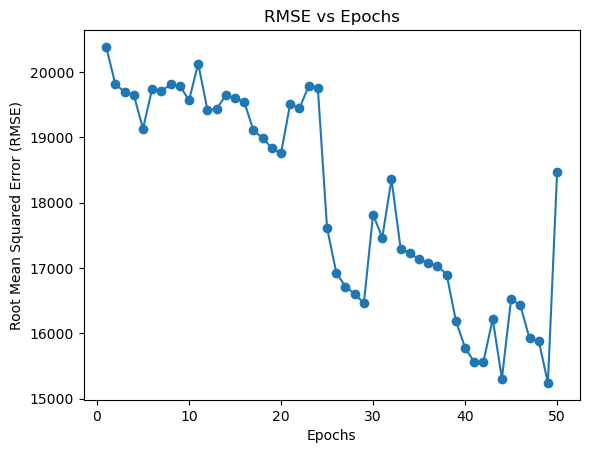

In [17]:
# Plot RMSE values for affected
plt.plot(range(1, pochs+1), rmse_values_affected, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('RMSE vs Epochs')
plt.show()

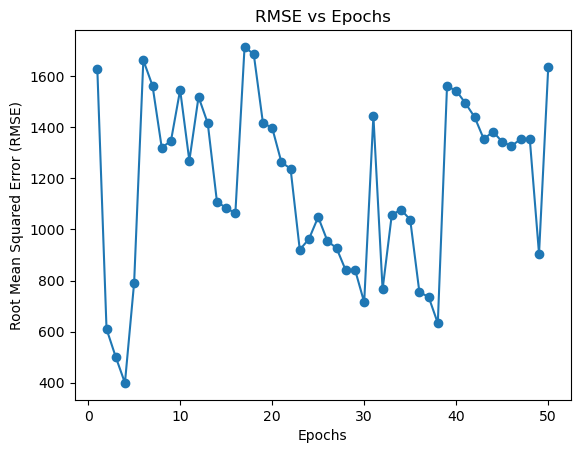

In [18]:
# Plot RMSE values for deaths
plt.plot(range(1, pochs+1), rmse_values_deaths, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('RMSE vs Epochs')
plt.show()


### Predictions on the test set


In [19]:
#print the prediction information
predictions

array([[ 1.8289899e+03, -4.5523660e+02],
       [ 8.7187854e+02,  8.6128197e+01],
       [ 1.0462152e+04, -5.8385210e+03],
       [ 2.2157877e+02, -3.3100655e+01],
       [ 9.2550269e+02, -3.3936655e+03],
       [ 4.3535083e+03, -1.3392679e+02],
       [ 1.8586024e+03,  3.7365732e+02],
       [ 3.2728830e+02, -5.3594070e+01],
       [ 8.2339160e+02,  1.5822656e+02],
       [ 2.7611035e+02, -3.2015676e+00],
       [ 2.3520976e+02, -3.2515121e+01],
       [ 3.5204827e+03,  3.6326718e+02],
       [ 7.5941802e+03,  4.2654709e+02],
       [ 8.1248846e+00, -1.3067350e+01],
       [ 6.4761163e+02, -1.6996808e+02],
       [ 1.6402782e+02, -6.3953255e+01],
       [ 8.7063641e+02,  4.8625458e+01],
       [ 4.2536554e+02,  1.9620514e+01],
       [ 5.7868599e+03,  3.0547971e+02],
       [ 7.0056396e+02, -4.7267850e+02]], dtype=float32)

In [20]:
predictions = model.predict(x_test)
# predictions= abs(predictions)
predictions

1/1 [==============================] - 0s 33ms/step


array([[ 1.8289899e+03, -4.5523660e+02],
       [ 8.7187854e+02,  8.6128197e+01],
       [ 1.0462152e+04, -5.8385210e+03],
       [ 2.2157877e+02, -3.3100655e+01],
       [ 9.2550269e+02, -3.3936655e+03],
       [ 4.3535083e+03, -1.3392679e+02],
       [ 1.8586024e+03,  3.7365732e+02],
       [ 3.2728830e+02, -5.3594070e+01],
       [ 8.2339160e+02,  1.5822656e+02],
       [ 2.7611035e+02, -3.2015676e+00],
       [ 2.3520976e+02, -3.2515121e+01],
       [ 3.5204827e+03,  3.6326718e+02],
       [ 7.5941802e+03,  4.2654709e+02],
       [ 8.1248846e+00, -1.3067350e+01],
       [ 6.4761163e+02, -1.6996808e+02],
       [ 1.6402782e+02, -6.3953255e+01],
       [ 8.7063641e+02,  4.8625458e+01],
       [ 4.2536554e+02,  1.9620514e+01],
       [ 5.7868599e+03,  3.0547971e+02],
       [ 7.0056396e+02, -4.7267850e+02]], dtype=float32)

#### r squired score for dengue affected case

In [21]:
rSquired = r2_score(y_test[:, 0], predictions[:, 0])
print(f'R-squared: {rSquired}')

R-squared: 0.07186087881818981


#### r squired score for dengue death case

In [22]:
r2 = r2_score(y_test[:, 1], predictions[:, 1])
print(f'R-squared: {r2}')

R-squared: -256.88163091976355


In [23]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(79, 10, 8)
(79, 2)
(20, 10, 8)
(20, 2)


In [24]:
print(predictions.shape)
print(y_test.shape)


 

(20, 2)
(20, 2)


In [25]:
print(y_test)
print(predictions)

print(type(y_test))
print(type(predictions))

[[4.3100e+02 2.0000e+00]
 [1.8000e+01 0.0000e+00]
 [7.9598e+04 3.9600e+02]
 [7.3000e+01 0.0000e+00]
 [4.0716e+04 2.7400e+02]
 [2.1932e+04 8.6000e+01]
 [9.0000e+00 0.0000e+00]
 [5.8000e+01 0.0000e+00]
 [1.4510e+03 3.0000e+00]
 [8.6900e+02 3.0000e+00]
 [5.2000e+01 0.0000e+00]
 [2.0000e+01 0.0000e+00]
 [1.6856e+04 2.5000e+01]
 [1.2600e+02 0.0000e+00]
 [1.8840e+03 6.0000e+00]
 [3.0000e+00 0.0000e+00]
 [3.4600e+02 2.0000e+00]
 [1.0770e+03 3.0000e+00]
 [1.6600e+02 3.0000e+00]
 [3.5670e+03 9.0000e+00]]
[[ 1.8289899e+03 -4.5523660e+02]
 [ 8.7187854e+02  8.6128197e+01]
 [ 1.0462152e+04 -5.8385210e+03]
 [ 2.2157877e+02 -3.3100655e+01]
 [ 9.2550269e+02 -3.3936655e+03]
 [ 4.3535083e+03 -1.3392679e+02]
 [ 1.8586024e+03  3.7365732e+02]
 [ 3.2728830e+02 -5.3594070e+01]
 [ 8.2339160e+02  1.5822656e+02]
 [ 2.7611035e+02 -3.2015676e+00]
 [ 2.3520976e+02 -3.2515121e+01]
 [ 3.5204827e+03  3.6326718e+02]
 [ 7.5941802e+03  4.2654709e+02]
 [ 8.1248846e+00 -1.3067350e+01]
 [ 6.4761163e+02 -1.6996808e+02]
 [ 1

## Performance mesure

### Designed a bar graph of actual dengue case VS predictive dengue case

In [26]:
print(y_test.shape)
print(predictions.shape)

(20, 2)
(20, 2)


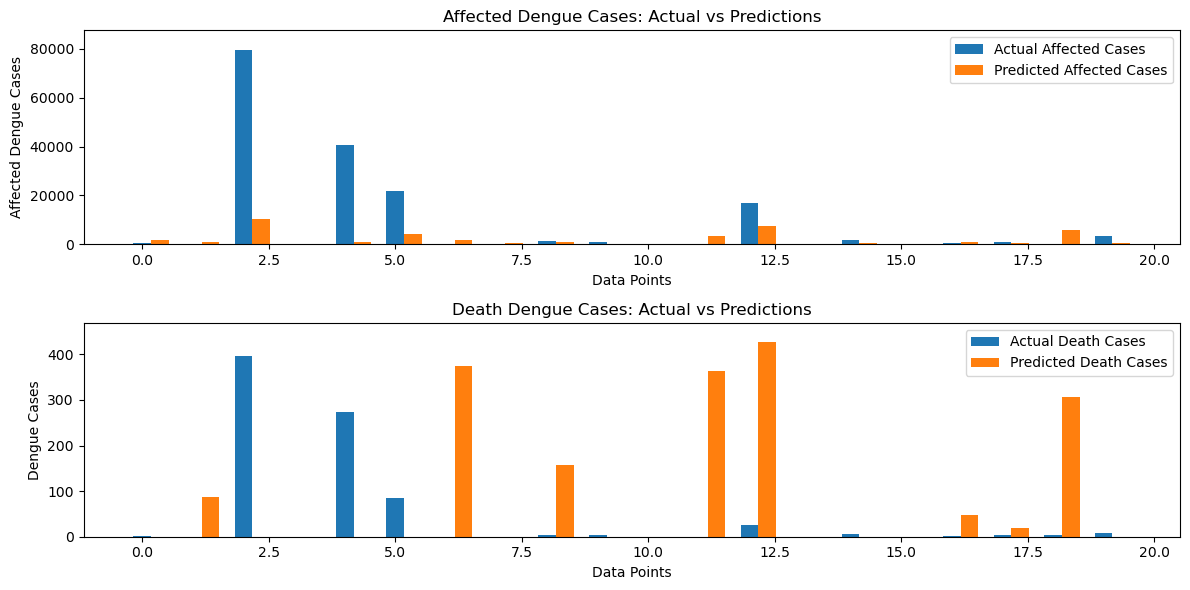

In [27]:
# Plot the bar graph for affected dengue cases
plt.figure(figsize=(12, 6))
bar_width = 0.35
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot

# Extract the first column of y_test (affected cases) for plotting
affected_actual = y_test[:, 0]  # Selecting the first column
affected_predicted = predictions[:, 0]  # Predicted affected cases

plt.bar(np.arange(len(affected_actual)), affected_actual, width=bar_width, label='Actual Affected Cases')
plt.bar(np.arange(len(affected_predicted)) + bar_width, affected_predicted, width=bar_width, label='Predicted Affected Cases')

plt.xlabel('Data Points')
plt.ylabel('Affected Dengue Cases')
plt.legend()
plt.title('Affected Dengue Cases: Actual vs Predictions')
plt.ylim(0, max(max(affected_actual), max(predictions[:, 0])) * 1.1)  # Set y-axis limit

plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
# Extract the actual and predicted death dengue cases
death_actual = y_test[:, 1]  # Actual death cases
death_predicted = predictions[:, 1]  # Predicted death cases
plt.bar(np.arange(len(death_actual)), death_actual, width=bar_width, label='Actual Death Cases')
plt.bar(np.arange(len(death_predicted)) + bar_width, death_predicted, width=bar_width, label='Predicted Death Cases')
plt.xlabel('Data Points')
plt.ylabel('Dengue Cases')
plt.legend()
plt.title('Death Dengue Cases: Actual vs Predictions')
plt.ylim(0, max(max(death_actual), max(predictions[:, 1])) * 1.1)  # Set y-axis limit

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()



###  Designed a graph of training loss and validation loss in times of dataset passing in the model.
 

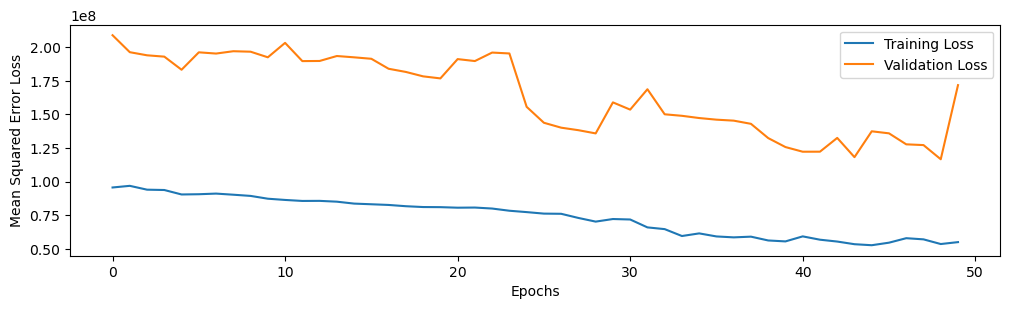

In [28]:
# Plot training and validation loss
plt.figure(figsize=(12, 3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error Loss')
plt.legend()
plt.show()

 


### R-squared (R²) ,0 to 1;  higher values indicating a better fit


In [29]:
# Compute R-squared
r2 = r2_score(y_test, predictions)

print(f'R-squared: {r2}')

R-squared: -128.40488502047273


##  RMSE VS Baseline of RMSE


In [30]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_test, predictions)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
mean_baseline_predictions = np.full_like(y_test, np.mean(y_test))

# Calculate RMSE Mean Baseline
rmse_mean_baseline = np.sqrt(mean_squared_error(y_test, mean_baseline_predictions))

print('Mean Squared Error (RMSE):',mse)
print('Root Mean Squared Error (RMSE)',rmse)
print(f'Mean Baseline RMSE: {rmse_mean_baseline}')

Mean Squared Error (RMSE): 171813828.92278704
Root Mean Squared Error (RMSE) 13107.777421164392
Mean Baseline RMSE: 14192.094760464359


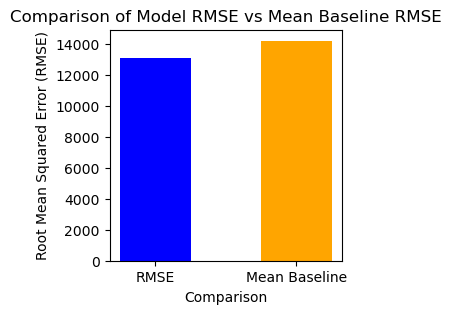

In [31]:
# bar difference more then better model
plt.figure(figsize=(3, 3))
plt.bar(['RMSE', 'Mean Baseline'], [rmse, rmse_mean_baseline], color=['blue', 'orange'], width=0.5)
plt.xlabel('Comparison')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Comparison of Model RMSE vs Mean Baseline RMSE')
plt.show()

## Dengue predict by other moedels

In [32]:
print(data)
print(y)

     YEAR  MONTH        MIN        MAX   HUMIDITY    RAINFALL
0    2015      1  13.548485  25.300000  68.976452   10.529000
1    2015      2  17.342424  28.712121  56.465000   16.500000
2    2015      3  19.669697  31.908824  48.826452   25.823529
3    2015      4  23.503030  32.485294  78.554333  192.911765
4    2015      5  25.263636  34.111765  85.996129  171.264706
..    ...    ...        ...        ...        ...         ...
103  2023      8  25.726471  31.373529  86.110000  420.364706
104  2023      9  25.355882  31.541176  85.910000  318.220588
105  2023     10  23.638235  31.526471  83.200000  160.314706
106  2023     11  19.176471  29.529412  79.090000   42.429412
107  2023     12  14.170588  26.432353  77.970000    9.638235

[108 rows x 6 columns]
     DENGUE  DEATHS
0         0       0
1         0       0
2         2       0
3         6       0
4        10       0
..      ...     ...
103   71976     342
104   79598     396
105   67769     359
106   40716     274
107    9288 

In [33]:
print(data.shape)
print(y.shape)

train_x, test_x, train_y, test_y = train_test_split(data, y, test_size=0.2, random_state=42)
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)


(108, 6)
(108, 2)
(86, 6)
(22, 6)
(86, 2)
(22, 2)


### Normalization

In [34]:
min_max_scaler = MinMaxScaler()
train_x = min_max_scaler.fit_transform(train_x)
test_x = min_max_scaler.transform(test_x)


### Standardization

In [35]:
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

#### Models build

In [36]:
# KNN model
model_k = KNeighborsClassifier(n_neighbors=3)
model_k.fit(train_x, train_y)
predictions_k = model_k.predict(test_x)
print('shape of x test', x_test.shape)
print(predictions_k)

# SVM model
model_s = SVC(kernel='poly', degree=2, C=2.0, gamma=1)  
multi_output_model = MultiOutputClassifier(model_s)
# Train the model
multi_output_model.fit(train_x, train_y)
# Make predictions
predictions_s = multi_output_model.predict(test_x)
print(predictions_s)

# Gradient Boosting Regressor model
model_g = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
# Wrap the model with MultiOutputRegressor to handle multiple target columns
multi_output_model_g = MultiOutputRegressor(model_g)
multi_output_model_g.fit(train_x, train_y)
predictions_g = multi_output_model_g.predict(test_x)
print(predictions_g)





shape of x test (20, 10, 8)
[[ 295    0]
 [ 145    0]
 [  38    0]
 [ 431    2]
 [   9    0]
 [ 737    1]
 [  28    0]
 [ 512    3]
 [3567    8]
 [ 126    0]
 [1571    4]
 [ 737    1]
 [  38    0]
 [3521   11]
 [  28    0]
 [8143   11]
 [1796    5]
 [  23    0]
 [3567    8]
 [ 267    0]
 [  38    0]
 [  92    0]]
[[ 2286     8]
 [  522     0]
 [   38     0]
 [ 9288     8]
 [   17     0]
 [ 7247     0]
 [16253    35]
 [ 8143    11]
 [ 9288     8]
 [  145     1]
 [  199     0]
 [  737     0]
 [   92    34]
 [   36    11]
 [   28     1]
 [   36     0]
 [52636     0]
 [  193     0]
 [17583   113]
 [  295     2]
 [   92    34]
 [  199     0]]
[[ 9.08012599e+02 -2.70780383e+00]
 [ 7.15592765e+02  2.30829448e+00]
 [ 3.33505029e+02 -6.17736507e-02]
 [ 2.61064180e+03  6.12009206e+00]
 [ 3.96890506e+02  1.21129314e+01]
 [ 7.20306272e+03  1.85527195e+01]
 [ 1.90896600e+03  5.27545758e+00]
 [ 1.43879095e+03  4.08693691e+00]
 [ 9.24702555e+03  4.65895740e+01]
 [ 3.63231529e+02  3.01934542e+00]
 [ 8

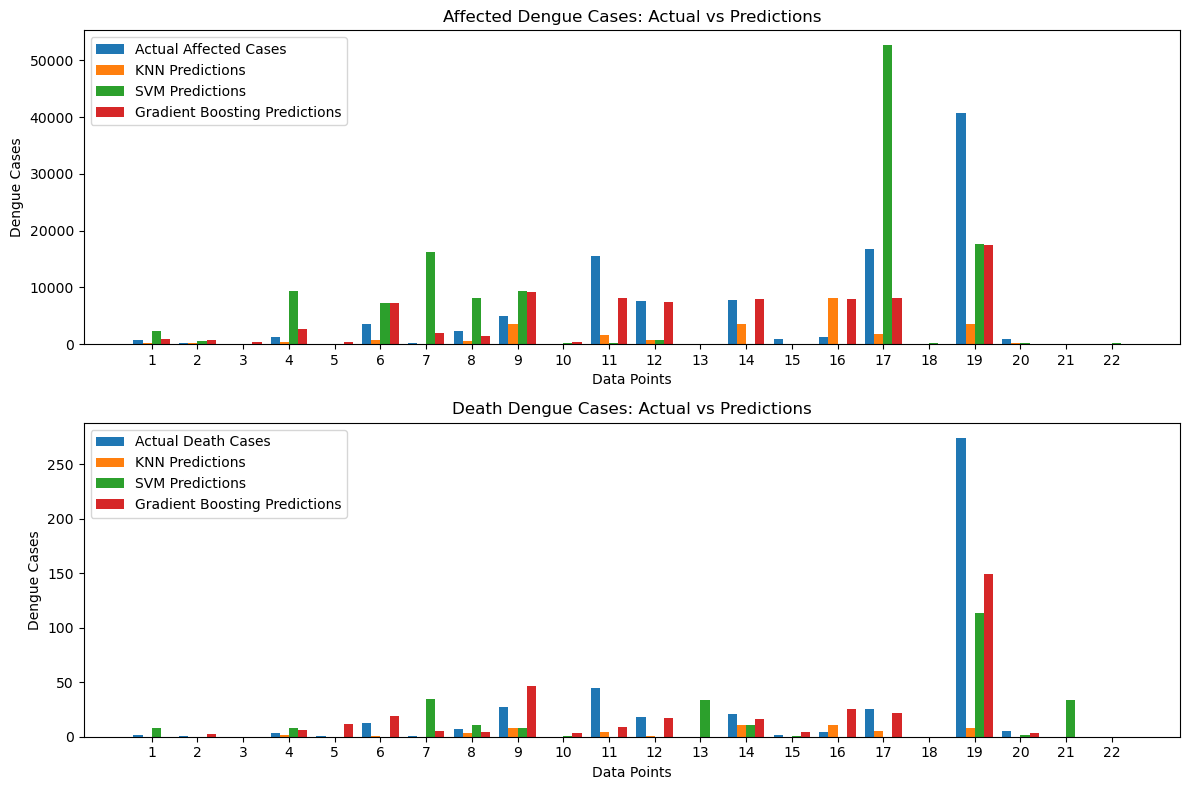

In [37]:
# Bar graph using subplots
plt.figure(figsize=(12, 8))

# Affected Dengue Cases subplot
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
bar_width = 0.2
indices = np.arange(len(test_y))
# maxDeath=max(predictions_k[:, 0]),
plt.bar(indices, test_y.to_numpy()[:, 0], width=bar_width, label='Actual Affected Cases')
plt.bar(indices + bar_width, predictions_k[:, 0], width=bar_width, label='KNN Predictions')
plt.bar(indices + 2 * bar_width, predictions_s[:, 0], width=bar_width, label='SVM Predictions')
plt.bar(indices + 3 * bar_width, predictions_g[:, 0], width=bar_width, label='Gradient Boosting Predictions')

plt.xlabel('Data Points')
plt.ylabel('Dengue Cases')
plt.xticks(indices + 1.5 * bar_width, indices + 1)
plt.legend()
plt.title('Affected Dengue Cases: Actual vs Predictions')
plt.ylim(0,)  # Set y-axis limit

# Death Dengue Cases subplot
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.bar(indices, test_y.to_numpy()[:, 1], width=bar_width, label='Actual Death Cases')
plt.bar(indices + bar_width, predictions_k[:, 1], width=bar_width, label='KNN Predictions')
plt.bar(indices + 2 * bar_width, predictions_s[:, 1], width=bar_width, label='SVM Predictions')
plt.bar(indices + 3 * bar_width, predictions_g[:, 1], width=bar_width, label='Gradient Boosting Predictions')

plt.xlabel('Data Points')
plt.ylabel('Dengue Cases')
plt.xticks(indices + 1.5 * bar_width, indices + 1)
plt.legend()
plt.title('Death Dengue Cases: Actual vs Predictions')
plt.ylim(0,)  # Set y-axis limit

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


LSTM(RMSE): 13107.777421164392
Gradient Boosting Regressor(RMSE): 4152.8529982762575
SVM(RMSE): 7609.027770591744
KNN(RMSE): 6623.263829110237


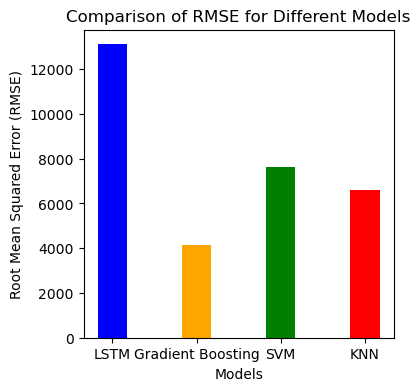

In [38]:
import matplotlib.pyplot as plt

# RMSE values for each model
rmse_lstm = rmse
rmse_gb = np.sqrt(mean_squared_error(test_y, predictions_g))
rmse_svm = np.sqrt(mean_squared_error(test_y, predictions_s))
rmse_knn = np.sqrt(mean_squared_error(test_y, predictions_k))

print("LSTM(RMSE):", rmse_lstm)
print("Gradient Boosting Regressor(RMSE):", rmse_gb)
print("SVM(RMSE):", rmse_svm)
print("KNN(RMSE):", rmse_knn)

# Plotting the bar graph
plt.figure(figsize=(4, 4))  # Adjust the figure size as needed
models = ['LSTM', 'Gradient Boosting', 'SVM', 'KNN']
rmse_values_affected = [rmse_lstm, rmse_gb, rmse_svm, rmse_knn]
bar_width = 0.35

plt.bar(models, rmse_values_affected, width=bar_width, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Comparison of RMSE for Different Models')
plt.show()


In [39]:
rSquired


0.07186087881818981

## 2024 dengue affected and death case predict

In [40]:

# Define the function to create sequences
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequence_end = i + sequence_length
        if sequence_end > len(data):
            break
        seq = data[i:sequence_end]
        sequences.append(seq)
    return np.array(sequences)

# Load the 2024 database
database2024 = pd.read_csv('C:/Users/User/anaconda3/Dengue/Database/2024-database-only.csv')
data = database2024[['YEAR', 'MONTH', 'MIN', 'MAX', 'HUMIDITY', 'RAINFALL']]

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data)

# Define the sequence length
sequence_length = 1

# Create sequences for training/testing
X_seq = create_sequences(X_scaled, sequence_length)
print('X_seq shape:', X_seq.shape)

# Assuming your model is already trained and loaded
# Define a placeholder for the predicted target variables
# below statement modify 2 column output is consider as 2 additional features of below code.
additional_features = np.zeros((X_seq.shape[0], X_seq.shape[1], 2))  # Assuming 2 additional features
dat = df[df['YEAR'] == 2019][['DENGUE', 'DEATHS']]
additional_features[:, :, :] = dat.values.reshape((dat.shape[0], 1, 2))

X_seq_with_additional_features = np.concatenate([X_seq, additional_features], axis=-1)

# Now X_seq_with_additional_features has shape (3, 10, 8)
# Now you can use X_seq_with_additional_features to make predictions
predictions = model.predict(X_seq_with_additional_features)

# Now you have the predictions for the target variables
print('Predictions shape:', predictions.shape)
print('Predictions:', predictions)


X_seq shape: (3, 10, 6)


ValueError: could not broadcast input array from shape (12,1,2) into shape (3,10,2)

In [ ]:
# import pandas as pd

# # Read the CSV file into a DataFrame
# df = pd.read_csv('C:/Users/User/anaconda3/Dengue/Database/DengueAndClimateBangladesh.csv')

# # Filter the DataFrame for rows where the year is 2019 and select specific columns
# dat = df[df['YEAR'] == 2019][['DENGUE', 'DEATHS']]

# # Print only the values without column names and index
# print(dat.to_string(header=False, index=False))


In [ ]:
# additional_features[:, :, :] = dat.values.reshape((dat.shape[0], 1, 2))
# additional_features

In [ ]:

# Months for x-axis (assuming 12 months)
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

# Extracting predicted values for affected and death dengue cases
predicted_affected_cases = [pred[0] for pred in predictions]
predicted_death_cases = [pred[1] for pred in predictions]

# Plotting the subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 9))

# Plot for combined affected and death cases
axs[0].bar(months, predicted_affected_cases, color='blue', alpha=0.7, label='Affected Cases')
axs[0].bar(months, predicted_death_cases, color='red', alpha=0.7, label='Death Cases')
axs[0].set_ylabel('Predicted Cases')
axs[0].set_title('Predicted Affected and Death Dengue Cases for 2024')
axs[0].legend()
axs[0].set_xticklabels(months, rotation=45)

# Plot for affected cases
axs[1].bar(months, predicted_affected_cases, color='blue', alpha=0.7, label='Affected Cases')
axs[1].set_ylabel('Affected Cases')
axs[1].set_title('Predicted Affected Dengue Cases for 2024')
axs[1].legend()
axs[1].set_xticklabels(months, rotation=45)

# Plot for death cases
axs[2].bar(months, predicted_death_cases, color='red', alpha=0.7, label='Death Cases')
axs[2].set_ylabel('Death Cases')
axs[2].set_title('Predicted Death Dengue Cases for 2024')
axs[2].legend()
axs[2].set_xticklabels(months, rotation=45)

plt.tight_layout()
plt.show()
